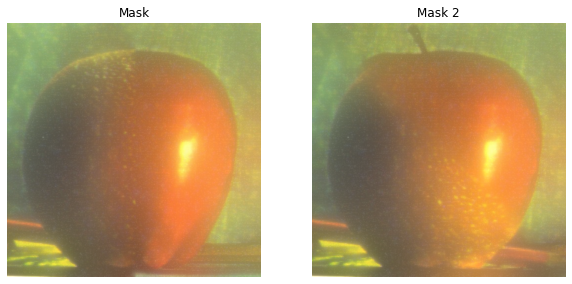

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 读取两幅输入图像
image1 = cv2.imread('image1.jpg')
image2 = cv2.imread('image2.jpg')

# 读取蒙版图像并转换为浮点数
mask = cv2.imread('mask.jpg', cv2.IMREAD_GRAYSCALE) / 255.0
mask2 = cv2.imread('mask2.jpg', cv2.IMREAD_GRAYSCALE) / 255.0

# 调整图像大小为2的幂次方
def resize_to_power_of_two(image):
    height, width, _ = image.shape
    new_height = 2 ** int(np.log2(height))
    new_width = 2 ** int(np.log2(width))
    return cv2.resize(image, (new_width, new_height))

image1 = resize_to_power_of_two(image1)
image2 = resize_to_power_of_two(image2)

# 构建高斯金字塔
def build_gaussian_pyramid(image, num_levels):
    pyramid = [image]
    for _ in range(num_levels):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

# 构建拉普拉斯金字塔
def build_laplacian_pyramid(image, num_levels):
    gaussian_pyramid = build_gaussian_pyramid(image, num_levels)
    pyramid = [gaussian_pyramid[num_levels]]
    for i in range(num_levels, 0, -1):
        expanded = cv2.pyrUp(gaussian_pyramid[i])
        laplacian = cv2.subtract(gaussian_pyramid[i - 1], expanded)
        pyramid.append(laplacian)
    return pyramid

# 图像融合
def blend_images(image1, image2, mask):
    # 构建拉普拉斯金字塔
    num_levels = 6  # 金字塔层级数
    laplacian_pyramid1 = build_laplacian_pyramid(image1, num_levels)
    laplacian_pyramid2 = build_laplacian_pyramid(image2, num_levels)

    # 合并两个图像的拉普拉斯金字塔
    blended_pyramid = []
    for l1, l2 in zip(laplacian_pyramid1, laplacian_pyramid2):
        rows, cols, _ = l1.shape
        mask_resized = cv2.resize(mask, (cols, rows))[:, :, np.newaxis]  # 调整蒙版大小并添加一个维度以匹配图像维度

        # 使用权重融合图像
        blended = (l1 * mask_resized) + (l2 * (1.0 - mask_resized))
        blended_pyramid.append(blended)

    # 重建融合后的图像
    blended_image = blended_pyramid[0]
    for i in range(1, num_levels + 1):
        blended_image = cv2.pyrUp(blended_image)
        blended_image += blended_pyramid[i]

    # 归一化像素值到 [0, 255] 范围内
    blended_image = np.clip(blended_image, 0, 255).astype(np.uint8)

    return blended_image

# 执行图像融合
result_mask = blend_images(image1, image2, mask)
result_mask2 = blend_images(image1, image2, mask2)

# 使用Matplotlib显示融合后的图像
plt.figure(figsize=(10,5))
plt.subplot(121), plt.imshow(cv2.cvtColor(result_mask, cv2.COLOR_BGR2RGB)), plt.title('Mask'), plt.axis('off')
plt.subplot(122), plt.imshow(cv2.cvtColor(result_mask2, cv2.COLOR_BGR2RGB)), plt.title('Mask 2'), plt.axis('off')
plt.show()